# Vertical Slice

## Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Data

In [2]:
mesh = xr.open_dataset('../data/model/orca05l75_domain_cfg_nemov5_10m.nc')
mesh

<xarray.Dataset>
Dimensions:       (y: 510, x: 720, nav_lev: 75, nlines: 54)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x, nlines
Data variables: (12/33)
    e1v           (y, x) float64 ...
    e2u           (y, x) float64 ...
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    glamt         (y, x) float64 ...
    glamu         (y, x) float64 ...
    ...            ...
    e3uw_0        (nav_lev, y, x) float64 ...
    e3vw_0        (nav_lev, y, x) float64 ...
    bottom_level  (y, x) int32 ...
    top_level     (y, x) int32 ...
    bathy_metry   (y, x) float64 ...
    namelist_cfg  (nlines) |S102 ...
Attributes:
    history:      Tue Sep 10 21:54:46 2024: ncap2 -O --ftn -s           /* Gi...
    CfgName:      ORCA
    CfgIndex:     5
    Iperio:       1
    Jperio:       0
    NFold:        1
    NFtype:       F
    VertCoord:    zps
    IsfCav:       0
    NEMOversion:  5.0
    NCO:          netCDF Operators version 5.2.8 (Homepage = http://nco.sf.ne...

In [3]:
model = xr.open_dataset('../data/model/nemo00_1m_201001_202212_Eq.nc')
model

<xarray.Dataset>
Dimensions:            (time_counter: 156, bnds: 2, y_grid_T: 1, x_grid_T: 720,
                        y_grid_U: 1, x_grid_U: 720, deptht: 75, depthu: 75)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... ...
    nav_lon_grid_T     (y_grid_T, x_grid_T) float32 ...
    nav_lat_grid_T     (y_grid_T, x_grid_T) float32 ...
    nav_lon_grid_U     (y_grid_U, x_grid_U) float32 ...
    nav_lat_grid_U     (y_grid_U, x_grid_U) float32 ...
  * deptht             (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * depthu             (depthu) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
Dimensions without coordinates: bnds, y_grid_T, x_grid_T, y_grid_U, x_grid_U
Data variables: (12/15)
    time_counter_bnds  (time_counter, bnds) datetime64[ns] ...
    deptht_bnds        (deptht, bnds) float32 ...
    depthu_bnds        (depthu, bnds) float32 ...
    to                 (time_counter, deptht, y_grid_T, x_grid_T) float32 ...
    so                 (time_counter, deptht, y_grid_T, x_grid_T) float32 ...
    uo                 (time_counter, depthu, y_grid_U, x_grid_U) float32 ...
    ...                 ...
    qsr_oce            (time_counter, y_grid_T, x_grid_T) float32 ...
    qt_oce             (time_counter, y_grid_T, x_grid_T) float32 ...
    empmr              (time_counter, y_grid_T, x_grid_T) float32 ...
    utau_ao            (time_counter, y_grid_T, x_grid_T) float32 ...
    vtau_ao            (time_counter, y_grid_T, x_grid_T) float32 ...
    precip             (time_counter, y_grid_T, x_grid_T) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    Conventions:                CF-1.6
    timeStamp:                  2024-Nov-26 10:58:47 GMT
    uuid:                       68529780-8421-4447-bcef-104342b5abdc
    NCO:                        netCDF Operators version 5.0.1 (Homepage = ht...
    name:                       nemo00_1d_19860101_19861231_0n110w
    description:                ocean T grid variables
    title:                      ocean T grid variables
    history:                    Fri Jun 06 09:42:10 2025: cdo monmean nemo00/...
    history_of_appended_files:  Sat Dec 28 19:01:54 2024: Appended file ../gd...
    frequency:                  mon
    CDO:                        Climate Data Operators version 1.9.10 (https:...

## Analysis

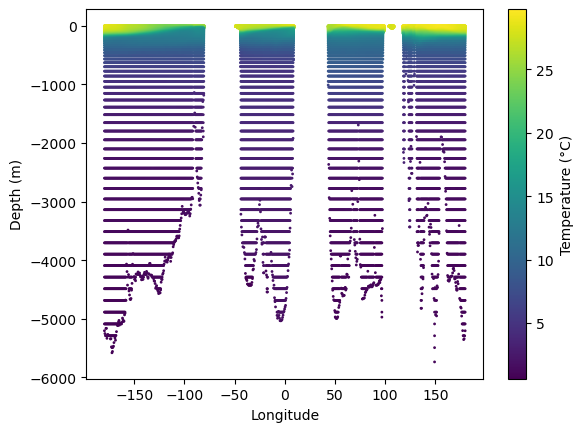

In [8]:
y = 249
nx = mesh.sizes["x"]
nlev = mesh.sizes["nav_lev"]
bottom_levels = mesh.bottom_level.sel(y=y).values  # shape (nx,)

valid_mask = np.zeros((nlev, nx), dtype=bool)
for x in range(nx):
    valid_mask[:bottom_levels[x], x] = True


# Create 2D longitude array by repeating the 1D longitude values across depth levels
lon2d = np.tile(model.nav_lon_grid_T.values, (nlev, 1))[valid_mask]

# Initialize a 2D depth array with nominal depth values (shape: [nlev, nx])
depth2d = np.repeat(model.deptht.values[:, np.newaxis], nx, axis=1)

# Adjust depth at the bottom level using vertical thickness (e3t_0) from the mesh
for x in range(nx):
    level = bottom_levels[x]
    if level > 0:  # skip land or invalid points
        if level > 1:
            # Add the vertical thickness to the depth just above
            thickness = mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=level - 1).values
            depth2d[level - 1, x] = depth2d[level - 2, x] + thickness
        else:
            # At the surface, just use the thickness
            depth2d[level - 1, x] = mesh.e3t_0.sel(y=y, x=x).isel(nav_lev=level - 1).values

# Flip depth to positive-downward convention and mask invalid points
depth1d = -depth2d[valid_mask]

# Extract valid temperature values
T = (model["to"].isel(time_counter=0, y_grid_T=0).values)
T1d = T[valid_mask]

# Plot temperature vs. longitude and depth
plt.scatter(lon2d, depth1d, c=T1d, s=1)
plt.xlabel("Longitude")
plt.ylabel("Depth (m)")
plt.colorbar(label="Temperature (°C)")
plt.show()